## Criando medidas de volatilidade no Python

In [401]:
# Importa as bibliotecas
from datetime import date 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
from arch import arch_model # roda o modelo garch

In [402]:
# Busca os preços ajustados de PETR4
ticker = 'BBDC4'
start = '2022-02-01'
end = date.today().isoformat()

stock = pdr.get_data_yahoo(f'{ticker}.SA', start=start, end=end)[['Adj Close']]
data = stock.copy()
# Transforma em retornos contínuos
data['log_return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

# compute sample standard deviation of returns
data['std_dev'] = data['log_return'].rolling(50).std()

# hystorycal annualized volatilty
data['hist_volatility'] = data['std_dev'] * ((252)**0.5)

# Retira os dados faltantes
data = data.dropna()
data.insert(loc=0, column='Ticker', value=ticker)



[*********************100%***********************]  1 of 1 completed


In [403]:
data

,Ticker,Adj Close,log_return,std_dev,hist_volatility
Date,,,,,
2022-04-14 00:00:00-03:00,BBDC4,18.314098,-0.002331,0.019917,0.316177
2022-04-18 00:00:00-03:00,BBDC4,18.638845,0.017577,0.019940,0.316535
2022-04-19 00:00:00-03:00,BBDC4,18.414623,-0.012103,0.019884,0.315643
2022-04-20 00:00:00-03:00,BBDC4,18.348755,-0.003583,0.019856,0.315201
2022-04-22 00:00:00-03:00,BBDC4,18.085283,-0.014463,0.019941,0.316557
...,...,...,...,...,...
2023-01-26 00:00:00-03:00,BBDC4,14.120487,0.002833,0.021056,0.334258
2023-01-27 00:00:00-03:00,BBDC4,13.701066,-0.030153,0.021216,0.336797
2023-01-30 00:00:00-03:00,BBDC4,13.770969,0.005089,0.021220,0.336856


##### Com a série em mãos, agora é necessário especificar o modelo utilizando arch_model. Além da série de retornos, escolhemos a ordem de p e q como 1, pois utilizaremos um GARCH(1,1). A média será constante e tomaremos a distribuição dos resíduos padronizados como normal.

In [404]:
# Especifica o modelo
gm = arch_model(data['log_return'][-50:], p = 1, q = 1,
                     mean = 'constant', vol = 'GARCH', dist = 'normal', rescale=False)

# Roda o modelo
gm_fit = gm.fit(disp = 'off')

##### Escolhido as configurações do modelo, "rodamos" ele com o método fit() e obtemos os resultados utilizando métodos e atributos do objeto. Através de params, obtemos os valores dos parâmetros estimados. Caso queiramos ver todos os valores produzidos, utilizamos summary().

In [405]:
# Visualiza os parâmetros
gm_fit.params

mu         -1.528301e-03
omega       2.941617e-05
alpha[1]    4.470420e-14
beta[1]     9.425219e-01
Name: params, dtype: float64

In [406]:
# Sumariza os resultados
print(gm_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                121.795
Distribution:                  Normal   AIC:                          -235.591
Method:            Maximum Likelihood   BIC:                          -227.942
                                        No. Observations:                   50
Date:                Thu, Feb 02 2023   Df Residuals:                       49
Time:                        16:16:16   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.5283e-03  2.975e-03     -0.514      0.

<AxesSubplot: xlabel='Date'>

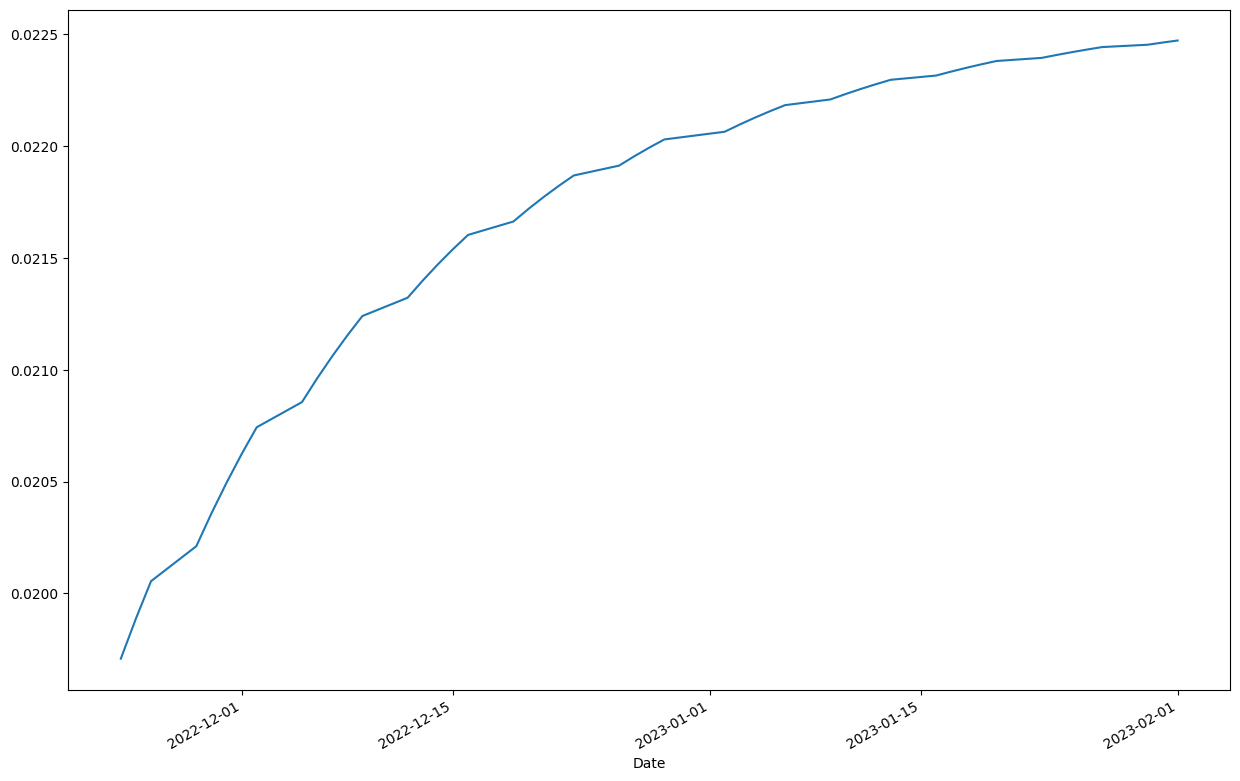

In [407]:
# Plota 
plt.figure(figsize=(15,10))
gm_fit.conditional_volatility.plot()

In [408]:
gm_fit.conditional_volatility

Date
2022-11-23 00:00:00-03:00    0.019708
2022-11-24 00:00:00-03:00    0.019887
2022-11-25 00:00:00-03:00    0.020054
2022-11-28 00:00:00-03:00    0.020211
2022-11-29 00:00:00-03:00    0.020357
2022-11-30 00:00:00-03:00    0.020494
2022-12-01 00:00:00-03:00    0.020622
2022-12-02 00:00:00-03:00    0.020742
2022-12-05 00:00:00-03:00    0.020855
2022-12-06 00:00:00-03:00    0.020961
2022-12-07 00:00:00-03:00    0.021060
2022-12-08 00:00:00-03:00    0.021153
2022-12-09 00:00:00-03:00    0.021240
2022-12-12 00:00:00-03:00    0.021322
2022-12-13 00:00:00-03:00    0.021399
2022-12-14 00:00:00-03:00    0.021471
2022-12-15 00:00:00-03:00    0.021539
2022-12-16 00:00:00-03:00    0.021603
2022-12-19 00:00:00-03:00    0.021663
2022-12-20 00:00:00-03:00    0.021719
2022-12-21 00:00:00-03:00    0.021772
2022-12-22 00:00:00-03:00    0.021822
2022-12-23 00:00:00-03:00    0.021868
2022-12-26 00:00:00-03:00    0.021913
2022-12-27 00:00:00-03:00    0.021954
2022-12-28 00:00:00-03:00    0.021993
2022-12

In [413]:
gm_volatility = gm_fit.conditional_volatility * 252 ** 0.5
gm_volatility = pd.DataFrame({'gm_volatility':gm_volatility.values}, index=gm_volatility.index)
gm_volatility.sort_index(ascending=False, inplace=True)
gm_volatility

,gm_volatility
Date,
2023-02-01 00:00:00-03:00,0.356734
2023-01-31 00:00:00-03:00,0.356588
2023-01-30 00:00:00-03:00,0.356432
2023-01-27 00:00:00-03:00,0.356268
2023-01-26 00:00:00-03:00,0.356093
2023-01-25 00:00:00-03:00,0.355907
2023-01-24 00:00:00-03:00,0.355710
2023-01-23 00:00:00-03:00,0.355501
2023-01-20 00:00:00-03:00,0.355279


##### Por fim, é possível realizar a previsão da variância utilizando o método forecast().



In [410]:
# Previsão

forecast = gm_fit.forecast(horizon = 5, reindex = False)

forecast.variance

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2023-02-01 00:00:00-03:00,0.000505,0.000506,0.000506,0.000506,0.000507


In [411]:
forecast_vol = (forecast.variance ** 0.5) * 252 ** 0.5
forecast_vol

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2023-02-01 00:00:00-03:00,0.35687,0.357,0.357123,0.357238,0.357346


In [412]:
data.sort_index(ascending=False, inplace=True)
garch_vol = data.join(gm_volatility).join(forecast_vol).fillna('-')
garch_vol

,Ticker,Adj Close,log_return,std_dev,hist_volatility,gm_volatility,h.1,h.2,h.3,h.4,h.5
Date,,,,,,,,,,,
2023-02-01 00:00:00-03:00,BBDC4,13.731025,-0.019446,0.021512,0.341494,0.356734,0.35687,0.357,0.357123,0.357238,0.357346
2023-01-31 00:00:00-03:00,BBDC4,14.000652,0.016541,0.021359,0.339061,0.356588,-,-,-,-,-
2023-01-30 00:00:00-03:00,BBDC4,13.770969,0.005089,0.021220,0.336856,0.356432,-,-,-,-,-
2023-01-27 00:00:00-03:00,BBDC4,13.701066,-0.030153,0.021216,0.336797,0.356268,-,-,-,-,-
2023-01-26 00:00:00-03:00,BBDC4,14.120487,0.002833,0.021056,0.334258,0.356093,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-22 00:00:00-03:00,BBDC4,18.085283,-0.014463,0.019941,0.316557,-,-,-,-,-,-
2022-04-20 00:00:00-03:00,BBDC4,18.348755,-0.003583,0.019856,0.315201,-,-,-,-,-,-
2022-04-19 00:00:00-03:00,BBDC4,18.414623,-0.012103,0.019884,0.315643,-,-,-,-,-,-
